In [ ]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)

In [2]:
from tcrdist.repertoire import TCRrep
import pwseqdist as pw

In [3]:
# Ruta del archivo
file_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu"

# Cargar el archivo MuData
mdata = mu.read_h5mu(file_path)

Adaptamos al estilo que quieren:

In [4]:
airr_df = ir.get.airr(mdata, airr_variable=[
    "sample_id", "cdr3", "junction_aa", "v_call", "j_call", "locus"
])

In [5]:
# Seleccionar solo las columnas necesarias para TCRdist3
airr_tcr = airr_df[[
    "VJ_1_sample_id", "VJ_1_cdr3", "VJ_1_junction_aa", "VJ_1_v_call", "VJ_1_j_call",
    "VDJ_1_cdr3", "VDJ_1_junction_aa", "VDJ_1_v_call", "VDJ_1_j_call"
]].copy()

# Renombrar columnas para `tcrdist3`
airr_tcr = airr_tcr.rename(columns={
    "VJ_1_sample_id": "sample_id",
    "VJ_1_cdr3": "cdr3_alpha",
    "VJ_1_junction_aa": "cdr3_a_aa",
    "VJ_1_v_call": "v_a_gene",
    "VJ_1_j_call": "j_a_gene",
    
    "VDJ_1_cdr3": "cdr3_beta",
    "VDJ_1_junction_aa": "cdr3_b_aa",
    "VDJ_1_v_call": "v_b_gene",
    "VDJ_1_j_call": "j_b_gene"
})

# Añadir `clone_id`, `clone_id_size` y `chain_pairing` desde `mdata["airr"].obs`
airr_tcr["clone_id"] = mdata["airr"].obs["clone_id"].reindex(airr_tcr.index)
airr_tcr["clone_id_size"] = mdata["airr"].obs["clone_id_size"].reindex(airr_tcr.index)

In [6]:
airr_tcr

,sample_id,cdr3_alpha,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_beta,cdr3_b_aa,v_b_gene,j_b_gene,clone_id,clone_id_size
cell_id,,,,,,,,,,,
AAACCTGAGAAGAAGC-1_PT14,PT_14,GCTGTGAGTGGAGGCGGCACAGGCTTTCAGAAACTTGTA,CAVSGGGTGFQKLVF,TRAV8-4*01,TRAJ8*01,GCCAGCAGCTTAGAGTCCCGTGGCAGCGCAGATACGCAGTAT,CASSLESRGSADTQYF,TRBV13*01,TRBJ2-3*01,0,23
AAACCTGAGGACAGAA-1_PT14,PT_14,GCAGAGAATACTGGAGGCTTCAAAACTATC,CAENTGGFKTIF,TRAV13-2*01,TRAJ9*01,GCCAGCAGCCTCCGCGAGGGTAGGACCTACAATGAGCAGTTC,CASSLREGRTYNEQFF,TRBV7-9*03,TRBJ2-1*01,1,1
AAACCTGAGTGGAGTC-1_PT14,PT_14,GCTCTGAGTGGGGTAGCTGCAGGCAACAAGCTAACT,CALSGVAAGNKLTF,TRAV9-2*02,TRAJ17*01,GCCAGCAGCCAGGACAACCACAATCAGCCCCAGCAT,CASSQDNHNQPQHF,TRBV7-9*03,TRBJ1-5*01,2,1
AAACCTGAGTGTCTCA-1_PT14,PT_14,GCTACGGCTAGGGTGCTGAAGCTCAGC,CATARVLKLSF,TRAV17*01,TRAJ20*01,GCCAGCAGCTTAGAGTTGCAGGGGAGTACCCTCGGGCAAGAGACCC...,CASSLELQGSTLGQETQYF,TRBV7-9*03,TRBJ2-5*01,3,1
AAACCTGCAAACTGTC-1_PT14,PT_14,GCAATGAGCGCGTTGAATGCTGGTGGTACTAGCTATGGAAAGCTGACA,CAMSALNAGGTSYGKLTF,TRAV12-3*01,TRAJ52*01,GCCAGCAGCCAACGGCGTCCCCCCTACAATGAGCAGTTC,CASSQRRPPYNEQFF,TRBV3-1*01,TRBJ2-1*01,4,1
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGTGGCTC-1_PT50,PT_50,GCAATGACCGGGATGAACACAGGCTTTCAGAAACTTGTA,CAMTGMNTGFQKLVF,TRAV12-3*01,TRAJ8*01,GCCAGCAGCTTAGTTGGGACAGGGGATGGCTACACC,CASSLVGTGDGYTF,TRBV5-6*01,TRBJ1-2*01,20321,70
TTTGTCATCGTGGGAA-1_PT50,PT_50,GGCACAGAGGAAAATTCTGGGGGTTACCAGAAAGTTACC,CGTEENSGGYQKVTF,TRAV30*01,TRAJ13*02,GCCAGCAGCTTGGGAAAGGATAAAGCTTTC,CASSLGKDKAFF,TRBV5-1*01,TRBJ1-1*01,20317,236
TTTGTCATCTGCTGCT-1_PT50,PT_50,GCTCTGAGTAAGGTGTCCGGTTCTGCAAGGCAACTGACC,CALSKVSGSARQLTF,TRAV9-2*02,TRAJ22*01,GCCAGCAGTGAGACGGCAGGGGCCTTCCTCTACGAGCAGTAC,CASSETAGAFLYEQYF,TRBV6-1*01,TRBJ2-7*01,20616,16


In [7]:
print(airr_tcr.columns)

Index(['sample_id', 'cdr3_alpha', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene',
       'cdr3_beta', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'clone_id',
       'clone_id_size'],
      dtype='object')


✅ Sí, cuanto menor es la distancia, más similares son los TCRs.

✅ Sí, con 49,000 células y 23,000 clones, usar la estrategia sparse es lo mejor, porque evita calcular distancias innecesarias entre clones muy diferentes y ahorra memoria.

✅ Sí, esta estrategia facilita la clasificación, ya que solo nos enfocamos en los TCRs más similares y reducimos el ruido de TCRs demasiado diferentes.

### Valores son los más estándar según la literatura y la docu de tcrdist3:

1️⃣ Métricas de distancia

Para calcular distancias, usamos pw.metrics.nb_vector_tcrdist, que es la métrica estándar en tcrdist3, optimizada con Numba.

Se aplicará a CDR3, CDR2, CDR1 y pMHC-facing loop (CDR2.5) en ambas cadenas.

✅ ¿Por qué usar nb_vector_tcrdist?

Es la métrica más rápida y optimizada (usa Numba).

Se basa en Dash et al. (2018), que es el enfoque más aceptado en la literatura.
    
Calcula una distancia ponderada considerando sustituciones, inserciones y deleciones.

2️⃣ Pesos de cada región (CDR3 > CDR1/CDR2)

El CDR3 es lo más importante para la especificidad del TCR, por eso se le da más peso.

CDR1 y CDR2 influyen menos en la especificidad, pero aún aportan información estructural.

Estos parámetros afectan la alineación y el cálculo de distancias:

CDR3 se recorta (ntrim=3, ctrim=2) para evitar posiciones poco informativas.

CDR1/CDR2 NO se recortan (ntrim=0, ctrim=0), porque tienen longitud fija en IMGT.

gap_penalty=4: Penaliza los gaps en la alineación (moderado).

fixed_gappos=False para CDR3 → Permite gaps en posiciones óptimas.

fixed_gappos=True para CDR1/CDR2 → Mantiene la estructura alineada por IMGT.

En tu conjunto de datos airr_tcr, tenías genes en las columnas v_a_gene, j_a_gene, v_b_gene, y j_b_gene que contenían algunos valores con varias opciones separadas por comas, como por ejemplo:

TRBV24-1*02,TRBV24/OR9-2*01.

Cuando estos valores se comparaban con la base de datos combo_xcr_2024-03-05.tsv, algunos genes no eran encontrados, ya que la base de datos no contiene las opciones 
separadas por comas.

Esto causaba que estos genes no fueran asignados correctamente o que se perdieran.

Además, había genes que no estaban presentes en la base de datos, lo que contribuía a la falta de mapeo.

Verificación de genes con comas: Se implementó una función que procesa las columnas v_a_gene, j_a_gene, v_b_gene, y j_b_gene del dataframe airr_tcr. La función revisa si un valor contiene comas:

Si hay comas (lo que indica que hay más de un gen potencial), la función divide el valor en dos genes y revisa cuál de ellos está presente en la base de datos.
Si ambos genes no están presentes, se mantiene el valor original (sin cambios).
Si uno de los genes está en la base de datos, se mantiene ese gen como válido y se actualiza el campo.

In [8]:
import pandas as pd

# Leer el archivo de referencia (base de datos combo)
combo_db = pd.read_csv('/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/combo_xcr_2024_expanded_enric.tsv', sep='\t')

# Filtrar la base de datos para que solo contenga genes del organismo "human"
combo_db_human = combo_db[combo_db['organism'] == 'human']

# Crear un conjunto con todos los genes humanos presentes en 'id'
combo_genes_human = set(combo_db_human['id'])

# Lista para acumular genes ausentes
missing_genes = set()

# Función para manejar genes con comas y mantener los originales si no se encuentran en la base de datos
def check_and_update_genes(genes):
    if isinstance(genes, str) and ',' in genes:
        # Separar los genes y verificar cuál está en la base de datos
        gene_list = genes.split(',')
        valid_genes = [gene for gene in gene_list if gene in combo_genes_human]
        
        if valid_genes:
            return valid_genes[0]  # Si al menos uno está en la base, tomar el primero
        else:
            missing_genes.update(gene_list)  # Si ninguno está, guardarlos como ausentes
            return genes  # Mantener el original
    elif isinstance(genes, str) and genes in combo_genes_human:
        return genes  # Si el gen ya está en la base de datos, devolverlo
    elif genes is not None:
        missing_genes.add(genes)  # Si no está en la base y no es None, guardarlo como ausente
    return genes  # Mantener el original

# Aplicar la función a cada columna de genes
for col in ['v_a_gene', 'j_a_gene', 'v_b_gene', 'j_b_gene']:
    airr_tcr[col] = airr_tcr[col].apply(check_and_update_genes)

# Crear el dataframe modificado
airr_tcr_modified = airr_tcr.copy()

# Mostrar los primeros registros
print(airr_tcr_modified[['v_a_gene', 'j_a_gene', 'v_b_gene', 'j_b_gene']].head())

# Mostrar los genes ausentes en la base de datos
filtered_missing_genes = sorted([gene for gene in missing_genes if gene is not None])  # Filtrar None antes de ordenar

print(f"\n🔴 Genes no encontrados en la base de datos ({len(filtered_missing_genes)} únicos):")
print(filtered_missing_genes)


                            v_a_gene   j_a_gene    v_b_gene    j_b_gene
cell_id                                                                
AAACCTGAGAAGAAGC-1_PT14   TRAV8-4*01   TRAJ8*01   TRBV13*01  TRBJ2-3*01
AAACCTGAGGACAGAA-1_PT14  TRAV13-2*01   TRAJ9*01  TRBV7-9*03  TRBJ2-1*01
AAACCTGAGTGGAGTC-1_PT14   TRAV9-2*02  TRAJ17*01  TRBV7-9*03  TRBJ1-5*01
AAACCTGAGTGTCTCA-1_PT14    TRAV17*01  TRAJ20*01  TRBV7-9*03  TRBJ2-5*01
AAACCTGCAAACTGTC-1_PT14  TRAV12-3*01  TRAJ52*01  TRBV3-1*01  TRBJ2-1*01

🔴 Genes no encontrados en la base de datos (0 únicos):
[]


In [9]:
unique_clones = airr_tcr_modified['clone_id'].nunique()
print("Número de clones únicos en airr_tcr_modified:", unique_clones)

Número de clones únicos en airr_tcr_modified: 23080


1. Procesar tu Repertorio Enriquecido (TILs)

In [23]:
# Crear el objeto TCRrep con ambas cadenas
tr = TCRrep(
    cell_df=airr_tcr_modified,
    organism="human",
    chains=["alpha", "beta"],
    compute_distances=False,
    store_all_cdr = True,
    db_file="/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/combo_xcr_2024_expanded_enric.tsv"
)

tr.cpus = 15

In [51]:
print(tr.clone_df.columns)

Index(['sample_id', 'cdr3_alpha', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene',
       'cdr3_beta', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'clone_id_size',
       'cdr1_a_aa', 'cdr2_a_aa', 'pmhc_a_aa', 'cdr1_b_aa', 'cdr2_b_aa',
       'pmhc_b_aa', 'count', 'clone_id'],
      dtype='object')


In [13]:
unique_clones = tr.clone_df['clone_id'].nunique()
print("Número de clones únicos en tr.clone_df:", unique_clones)


Número de clones únicos en tr.clone_df: 17351


CADA FILA ES UN CLON NO UNA CÉLULA.

In [52]:
# Filtrar solo las filas que NO están en `show_incomplete()`
df_complete = tr.clone_df.drop(tr.show_incomplete().index, errors="ignore")

# Verificar si `cell_id` y `sample_id` están en airr_tcr_modified y unirlos
if "cell_id" in airr_tcr_modified.columns and "sample_id" in airr_tcr_modified.columns:
    df_complete = df_complete.merge(
        airr_tcr_modified[["cell_id", "sample_id"]],
        left_index=True, right_index=True, how="left"
    )

# Mostrar las primeras filas
import pandas as pd
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas sin truncar
print("📌 Asignaciones COMPLETAS de CDR1 y CDR2 en `airr_tcr_modified`")
display(df_complete.head())

📌 Asignaciones COMPLETAS de CDR1 y CDR2 en `airr_tcr_modified`


,sample_id,cdr3_alpha,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_beta,cdr3_b_aa,v_b_gene,j_b_gene,clone_id_size,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id
0,PT_14,ACCAACGACTACAAGCTCAGC,CTNDYKLSF,TRAV26-1*01,TRAJ20*01,GCCAGCAGCCAATGGACAGGGGGCCGTTCTGAAGCTTTC,CASSQWTGGRSEAFF,TRBV3-1*01,TRBJ1-1*01,1,TISG.....NEY,GLK.....NN,TEDRKS,LGH.......DT,YNN....KEL,P.DKAH,1,1
1,PT_14,AGAACCCCTTCAGCCAGTCAGGGAGCCCAGAAGCTGGTA,CRTPSASQGAQKLVF,TRAV26-1*02,TRAJ54*01,GCCAGCAGTTACTCAGCAGGGGCGCCCCAGCAT,CASSYSAGAPQHF,TRBV6-5*01,TRBJ1-5*01,1,TISG.....NEY,GLK.....NN,TEDRKS,MNH.......EY,SVG....AGI,S.TTED,1,2
2,PT_14,ATCCAGAAAGAAACCAGTGGCTCTAGGTTGACC,CIQKETSGSRLTF,TRAV26-2*01,TRAJ58*01,GCCAGCAGTTTGGGGCAGGGATATCGGCCCATATAT,CASSLGQGYRPIYF,TRBV12-4*01,TRBJ1-3*01,1,TISG.....TDY,GLT.....SN,AEDRKS,SGH.......DY,FNN....NVP,P.NASF,1,3
3,PT_14,ATCCCGGCTTTAGGGAATGCAGGCAACATGCTCACC,CIPALGNAGNMLTF,TRAV26-2*01,TRAJ39*01,GCTAGTGGTCGAACCCAAGACGGGACTAGCGGGAGTGGGGAGACCC...,CASGRTQDGTSGSGETQYF,TRBV12-5*01,TRBJ2-5*01,1,TISG.....TDY,GLT.....SN,AEDRKS,LGH.......NT,FRN....RAP,P.DATL,1,4
4,PT_14,ATCCGAAATAATGCAGGCAACATGCTCACC,CIRNNAGNMLTF,TRAV26-2*01,TRAJ39*01,GCCAGCAGCTTAGTCAGCAGGGGTAACTATGGCTACACC,CASSLVSRGNYGYTF,TRBV11-2*03,TRBJ1-2*01,1,TISG.....TDY,GLT.....SN,AEDRKS,SGH.......AT,FQN....NGV,L.KGVD,1,5


In [15]:
# Extraer datos incompletos
df_incomplete = tr.show_incomplete()

# Añadir `chain_pairing` desde `mdata["airr"].obs`
df_incomplete["chain_pairing"] = mdata["airr"].obs["chain_pairing"].reindex(df_incomplete.index)

# Contar la proporción de cada tipo de `chain_pairing`
chain_pair_counts = df_incomplete["chain_pairing"].value_counts(normalize=True) * 100

# Mostrar los primeros registros de los datos incompletos
import pandas as pd
pd.set_option('display.max_columns', None)  # Para visualizar todas las columnas sin truncar
print("📌 Datos Incompletos con Chain Pairing:")
display(df_incomplete.head())

# Mostrar la proporción de cada tipo de `chain_pairing`
print("\n📊 Proporción de tipos de chain_pairing en los datos incompletos:")
chain_pair_counts

📌 Datos Incompletos con Chain Pairing:


,sample_id,cdr3_alpha,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_beta,cdr3_b_aa,v_b_gene,j_b_gene,clone_id_size,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,cdr3_a_aa,cdr3_b_aa,chain_pairing
cell_id,,,,,,,,,,,,,,,,,,,
AAACCTGCACAGCCCA-1_PT14,None,None,None,None,None,GCCAGCCAAGACCCTACGAGGTCCTACGAGCAGTAC,CASQDPTRSYEQYF,TRBV6-6*01,TRBJ2-7*01,1,None,None,None,MNH.......NY,SVG....AGI,S.TTED,None,CASQDPTRSYEQYF,orphan VDJ
AAACGGGAGTATTGGA-1_PT14,None,None,None,None,None,GCCAGCAGCTTTGGGAGCAGTCCGGCTTCCTACGAGCAGTAC,CASSFGSSPASYEQYF,TRBV5-1*01,TRBJ2-7*01,1,None,None,None,SGH.......RS,YFS....ETQ,F.SNSR,None,CASSFGSSPASYEQYF,orphan VDJ
AAACGGGCACCAGTTA-1_PT14,None,None,None,None,None,GCCAGCAGCTTACAGGAAAGCACAGATACGCAGTAT,CASSLQESTDTQYF,TRBV5-8*01,TRBJ2-3*01,1,None,None,None,SGH.......TS,YDE....GEE,F.PNYS,None,CASSLQESTDTQYF,orphan VDJ
AAACGGGGTGAAATCA-1_PT14,None,None,None,None,None,GCCAGCAGTTTATCGGCGGATACAACTAATGAAAAACTGTTT,CASSLSADTTNEKLFF,TRBV27*01,TRBJ1-4*01,14,None,None,None,MNH.......EY,SMN....VEV,K.EKRN,None,CASSLSADTTNEKLFF,orphan VDJ
AAACGGGGTTCCACGG-1_PT14,None,None,None,None,None,GCCAGCAGCGTGGGGATGGATAATTCACCCCTCCAC,CASSVGMDNSPLHF,TRBV9*01,TRBJ1-6*01,1,None,None,None,SGD.......LS,YYN....GEE,F.PDLH,None,CASSVGMDNSPLHF,orphan VDJ



📊 Proporción de tipos de chain_pairing en los datos incompletos:


chain_pairing
orphan VDJ         93.425538
orphan VJ           6.574462
extra VJ            0.000000
extra VDJ           0.000000
single pair         0.000000
two full chains     0.000000
Name: proportion, dtype: float64

In [53]:
tr.compute_distances()

In [54]:
from scipy.sparse import csr_matrix

# Convertimos la matriz pw_beta a dispersa, sin aplicar radio artificial
tr.rw_beta = csr_matrix(tr.pw_beta)
print("Matriz dispersa rw_beta creada:", tr.rw_beta.shape)


Matriz dispersa rw_beta creada: (17351, 17351)


In [55]:
import numpy as np

# Ver la distribución de las distancias para definir un radio dinámico
percentiles = np.percentile(tr.pw_beta[tr.pw_beta > 0], [25, 50, 75, 90])
print("Percentiles de distancia:", percentiles)


Percentiles de distancia: [129. 145. 162. 177.]


✅ Aquí cada clon tiene sus k vecinos más cercanos, sin aplicar ningún radio artificial.

✅ Luego podemos definir un radio basado en percentiles de las distancias

2. Generar el Fondo de Referencia

Para generar un fondo artificial para humanos, deberás usar alguna función o método que permita sintetizar un repertorio de control basado en los sesgos de recombinación conocidos (por ejemplo, distribución de genes V y J). En el ejemplo del tutorial se usa:

Un muestreador (_default_sampler) para ratón, y
La función synthesize_vj_matched_background para crear el fondo.

In [ ]:
#from tcrsampler.setup_db import install_all_next_gen; install_all_next_gen(dry_run=False)

In [56]:
from tcrdist.sample import _default_sampler
from tcrdist.background import get_stratified_gene_usage_frequency

ts = _default_sampler(organism="human", chain="beta")()  # Esto genera una muestra para cadenas beta
ts = get_stratified_gene_usage_frequency(ts=ts, replace=True)

britanova_human_beta_t_cb.tsv.sampler.tsv


In [57]:
# 🔹 SINTETIZAR un repertorio de fondo basado en genes VJ sin sesgo del dataset real
df_vj_background = tr.synthesize_vj_matched_background(ts=ts, chain='beta')

MAKING A V-GENE, J-GENE MATCHED BACKGROUND.
USING STRATIFIED FREQUENCIES.
CALCULATE INVERSE PROBABILITY WEIGHT ADJUSTMENT.


Se ha generado el fondo (background) correctamente, emparejando V y J y calculando el ajuste de ponderación inversa. En este punto, tienes un DataFrame llamado df_vj_background que contiene TCR sintetizados de fondo para la cadena beta. El siguiente paso es usar este fondo para calcular los radios específicos para cada TCR en tu repertorio enriquecido (en tu caso, tus TILs).

3. Crear el Objeto de Fondo

Aunque ya tienes el DataFrame df_vj_background, es recomendable cargarlo en un objeto TCRrep (o similar) para que puedas utilizar todas las funciones de TCRdist3 sobre el fondo.

In [58]:
tr_bkgd = TCRrep(
    cell_df = df_vj_background.copy(),  # Asegúrate de copiar para evitar modificaciones accidentales
    organism = "human",
    chains = ["beta"],
    db_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/combo_xcr_2024_expanded_enric.tsv",
    compute_distances = False  # No es necesario calcular las distancias para el fondo si solo se usa para comparación
)
print(f"Tamaño del background: {len(df_vj_background)}")

Tamaño del background: 100000


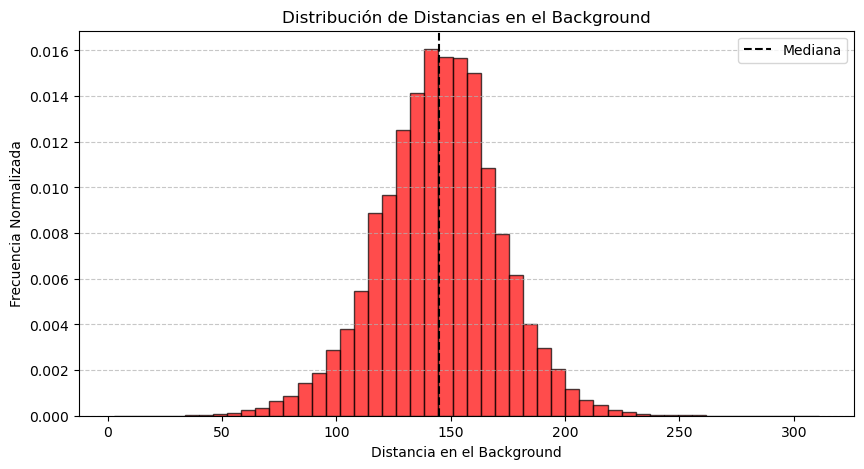

Percentiles de distancia en el background: [129. 145. 162. 177.]


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Extraer las distancias de la matriz rw_beta en el background
distances_background = tr.rw_beta.toarray().flatten()

# 🔹 Filtrar valores > 0 para evitar conteo de 0s (misma célula)
distances_background = distances_background[distances_background > 0]

# 🔹 Graficar histograma de las distancias en el background
plt.figure(figsize=(10, 5))
plt.hist(distances_background, bins=50, alpha=0.7, color='red', edgecolor='black', density=True)
plt.xlabel("Distancia en el Background")
plt.ylabel("Frecuencia Normalizada")
plt.title("Distribución de Distancias en el Background")
plt.axvline(np.median(distances_background), color='black', linestyle='dashed', label="Mediana")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 🔹 Ver los percentiles de la distribución de distancias
percentiles_background = np.percentile(distances_background, [25, 50, 75, 90])
print(f"Percentiles de distancia en el background: {percentiles_background}")

4. Calcular los Radios Específicos para Cada TCR en Tus TILs

Ahora que ya tienes tanto tu repertorio enriquecido (tr) como el fondo (tr_bkgd), puedes calcular el radio óptimo para cada TCR usando la función calc_radii.
    
Esto te permitirá saber, para cada clon en tr, hasta qué distancia considerar vecinos para lograr la tasa de descubrimiento controlada en el fondo.

La función calc_radii compara la densidad de vecinos en el fondo con la deseada (1/10^5 en este ejemplo) y ajusta para cada TCR un radio de búsqueda. Los objetos thresholds y ecdfs te ayudarán a visualizar o validar la distribución de distancias, pero el elemento clave es el vector radii.

Aunque al crear el objeto TCRrep conservas la información de ambas cadenas (alfa y beta), la matriz de distancia que se utiliza para calcular los radios y determinar los vecinos se calcula únicamente sobre la cadena beta, ya que se considera que ésta define de forma más robusta el clonotipo.

In [64]:
from tcrdist.centers import calc_radii

# Guardar la configuración original
original_chains = tr.chains.copy()
tr.chains = ["beta"]  # Solo trabajamos con la cadena beta
### 🔹 PASO 1: Calcular `radius` usando los vecinos en `tr`
sorted_distances = np.sort(tr.pw_beta, axis=1)  # Ordenamos las distancias por fila
k = 3  # Tomamos el tercer vecino más cercano
tr.clone_df['radius'] = sorted_distances[:, k]  # Asignamos la distancia al k-ésimo vecino

### 🔹 PASO 2: Calcular `radius_background` basado en `tr_bkgd`
radii_background, thresholds_bkgd, ecdfs_bkgd = calc_radii(
    tr = tr,
    tr_bkgd = tr_bkgd,  
    chain = 'beta',       
    ctrl_bkgd = 10**-5,    
    use_sparse = True, 
    max_radius=50  # el valor maximo al que se ajustan.
)

tr.clone_df['radius_background'] = radii_background

# Restaurar la configuración original
tr.chains = original_chains


COMPUTING ECDFS PER TCR, TO FIND APPROPRIATE MAX RADII AT 1e-05
RETURNING LIST OF MAX RADII


In [65]:
from tcrdist.public import _neighbors_sparse_variable_radius, _neighbors_variable_radius

# 🟢 Vecinos en el repertorio principal (dataset real)
tr.clone_df['neighbors'] = _neighbors_variable_radius(
    pwmat = tr.pw_beta,  
    radius_list = tr.clone_df['radius']
)

# 🟢 Vecinos en el background
tr.clone_df['background_neighbors'] = _neighbors_sparse_variable_radius(
    csrmat = tr.rw_beta,  
    radius_list = tr.clone_df['radius']
)

# 🟢 Número de vecinos en cada caso
tr.clone_df['n_neighbors'] = tr.clone_df['neighbors'].apply(len)
tr.clone_df['n_background_neighbors'] = tr.clone_df['background_neighbors'].apply(len)

# 🔍 Revisión de los datos
print(tr.clone_df[['clone_id', 'radius', 'neighbors', 'radius_background', 'background_neighbors']].head())

   clone_id  radius                                       neighbors  \
0         1      45  [0, 4489, 4512, 4812, 4901, 5737, 9022, 12494]   
1         2      36      [1, 2552, 8422, 8823, 12552, 13695, 15249]   
2         3      43                         [2, 4415, 10899, 13185]   
3         4      75                            [3, 822, 1028, 1559]   
4         5      45                          [4, 1344, 9215, 13056]   

   radius_background                         background_neighbors  
0                 32  [4489, 4512, 4812, 4901, 5737, 9022, 12494]  
1                 22      [2552, 8422, 8823, 12552, 13695, 15249]  
2                 30                         [4415, 10899, 13185]  
3                 48                            [822, 1028, 1559]  
4                 40                          [1344, 9215, 13056]  


In [66]:
tr.clone_df[['clone_id', 'radius', 'neighbors', 'radius_background', 'background_neighbors']]

,clone_id,radius,neighbors,radius_background,background_neighbors
0,1,45,"[0, 4489, 4512, 4812, 4901, 5737, 9022, 12494]",32,"[4489, 4512, 4812, 4901, 5737, 9022, 12494]"
1,2,36,"[1, 2552, 8422, 8823, 12552, 13695, 15249]",22,"[2552, 8422, 8823, 12552, 13695, 15249]"
2,3,43,"[2, 4415, 10899, 13185]",30,"[4415, 10899, 13185]"
3,4,75,"[3, 822, 1028, 1559]",48,"[822, 1028, 1559]"
4,5,45,"[4, 1344, 9215, 13056]",40,"[1344, 9215, 13056]"
...,...,...,...,...,...
17346,17347,24,"[2063, 9174, 15055, 17346]",26,"[2063, 9174, 15055]"
17347,17348,24,"[6361, 7107, 10430, 17347]",22,"[6361, 7107, 10430]"
17348,17349,54,"[1713, 7571, 12432, 17348]",48,"[1713, 7571, 12432]"
17349,17350,60,"[3269, 10778, 11307, 12212, 13323, 17349]",48,"[3269, 10778, 11307, 12212, 13323]"


In [67]:
num_sin_vecinos = (tr.clone_df['radius_background'] == 0).sum()
print(f"TCRs sin vecinos con max_radius=50: {num_sin_vecinos} ({num_sin_vecinos / len(tr.clone_df) * 100:.2f}%)")


TCRs sin vecinos con max_radius=50: 0 (0.00%)


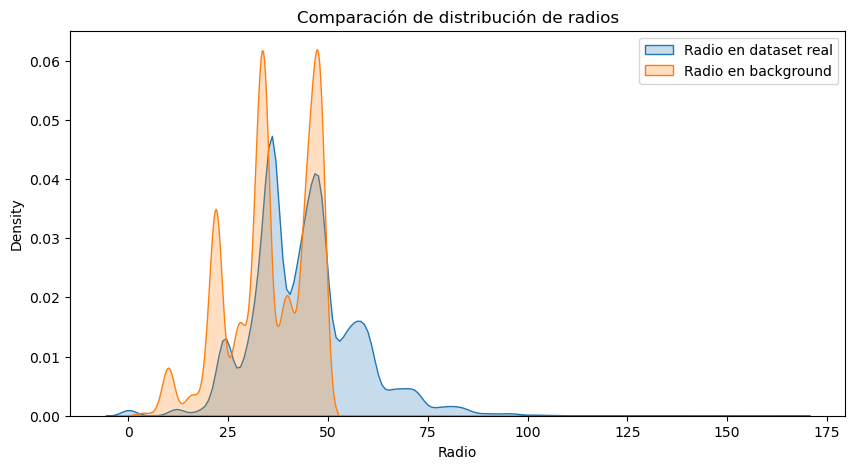

In [95]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(tr.clone_df['radius'], label="Radio en dataset real", fill=True)
sns.kdeplot(tr.clone_df['radius_background'], label="Radio en background", fill=True)
plt.xlabel("Radio")
plt.title("Comparación de distribución de radios")
plt.legend()
plt.show()

Interpretación:
Un radio pequeño sugiere que el clon se encuentra en una zona donde hay pocos TCR similares, lo que podría indicar un clon relativamente único o poco común.

Un radio grande implica que en esa región del espacio de distancias existen muchos TCR similares, lo que puede ser una señal de convergencia (por ejemplo, clonotipos recurrentes o quasi-public).

El radio se utiliza para definir el vecindario de cada clon, es decir, cuáles otros clonotipos se consideran suficientemente cercanos para ser comparados en términos de similitud o para evaluar la quasi-publicity.

Aunque el radio se calcula únicamente con la información de la cadena beta, clone_df conserva los datos de ambas cadenas (alfa y beta). Por eso, cada clon tiene asociado su radio derivado de beta, pero no se pierde la información de la cadena alfa.

5. Probabilidad de Generación:

La probabilidad de generación, Pgen, definida por Walczyk y colegas e implementada en Python por Sethna et al. (2019), es otra forma de filtrar TCR y vecindarios de TCR que son más frecuentes de lo esperado en función de su probabilidad de producirse a través de la recombinación en fases tempranas del desarrollo inmunológico

Evaluar la Rareza de las Secuencias de CDR3:

Pgen es la probabilidad de que una secuencia de CDR3 se genere por azar a través del proceso de recombinación V(D)J.

Un valor de Pgen muy bajo indica que la secuencia es poco probable de formarse aleatoriamente. Esto puede ser un indicativo de que la secuencia ha sido fuertemente seleccionada, por ejemplo, en respuesta a un antígeno específico.

Debido a que Pgen suele ser un número muy pequeño, se transforma a -log10(Pgen) para facilitar la interpretación y visualización.
En esta escala, valores altos de -log10(Pgen) corresponden a secuencias que son muy raras (es decir, que tienen una probabilidad de generación muy baja), lo que puede sugerir una fuerte presión selectiva.

### Lo aplicamos sobre el tf.clone_df

In [14]:
import parmap
import numpy as np
from tcrdist.pgen import OlgaModel
from scipy.stats import zscore

# Crea el modelo OLGA para la cadena beta (VDJ)
olga_beta = OlgaModel(chain_folder="human_T_beta", recomb_type="VDJ")

# Calcula Pgen en paralelo para cada secuencia de CDR3 beta
tr.clone_df['pgen_cdr3_b_aa'] = parmap.map(
    olga_beta.compute_aa_cdr3_pgen, 
    tr.clone_df['cdr3_b_aa'], 
    pm_processes=12,  
    pm_pbar=True      
)

# Obtener el mínimo valor real de Pgen para evitar valores 0
min_pgen_real = tr.clone_df['pgen_cdr3_b_aa'][tr.clone_df['pgen_cdr3_b_aa'] > 0].min()

# Si hay ceros, reemplazarlos por el mínimo valor real observado
tr.clone_df['pgen_cdr3_b_aa'] = tr.clone_df['pgen_cdr3_b_aa'].replace(0, min_pgen_real)

# Aplicar -log10(Pgen)
tr.clone_df['pgen_cdr3_b_aa_nlog10'] = -np.log10(tr.clone_df['pgen_cdr3_b_aa'])

# Aplicar Z-score a -log10(Pgen), asegurando que no haya valores extremos
tr.clone_df['pgen_cdr3_b_aa_nlog10_z'] = zscore(tr.clone_df['pgen_cdr3_b_aa_nlog10'])

# Mostrar información final
print(tr.clone_df[['pgen_cdr3_b_aa', 'pgen_cdr3_b_aa_nlog10', 'pgen_cdr3_b_aa_nlog10_z']].describe())



  0%|          | 0/17351 [00:00<?, ?it/s]

       pgen_cdr3_b_aa  pgen_cdr3_b_aa_nlog10  pgen_cdr3_b_aa_nlog10_z
count    1.735100e+04           17351.000000             1.735100e+04
mean     5.022144e-08               9.202027             5.385071e-17
std      2.046706e-07               2.094372             1.000029e+00
min      8.101521e-26               5.317944            -1.854587e+00
25%      6.243952e-11               7.761566            -6.877971e-01
50%      1.477966e-09               8.830335            -1.774767e-01
75%      1.731548e-08              10.204540             4.786839e-01
max      4.809014e-06              25.091433             7.586935e+00


In [17]:
# Crea el modelo OLGA para la cadena alfa (VJ)
olga_alpha = OlgaModel(chain_folder="human_T_alpha", recomb_type="VJ")

# Calcula Pgen en paralelo para cada secuencia de CDR3 alfa
tr.clone_df['pgen_cdr3_a_aa'] = parmap.map(
    olga_alpha.compute_aa_cdr3_pgen,
    tr.clone_df['cdr3_a_aa'],
    pm_processes=12,
    pm_pbar=True
)

# Obtener el mínimo valor real de Pgen para evitar valores 0
min_pgen_real_a = tr.clone_df['pgen_cdr3_a_aa'][tr.clone_df['pgen_cdr3_a_aa'] > 0].min()

# Si hay ceros, reemplazarlos por el mínimo valor real observado
tr.clone_df['pgen_cdr3_a_aa'] = tr.clone_df['pgen_cdr3_a_aa'].replace(0, min_pgen_real_a)

# Aplicar -log10(Pgen)
tr.clone_df['pgen_cdr3_a_aa_nlog10'] = -np.log10(tr.clone_df['pgen_cdr3_a_aa'])

# Aplicar Z-score a -log10(Pgen)
tr.clone_df['pgen_cdr3_a_aa_nlog10_z'] = zscore(tr.clone_df['pgen_cdr3_a_aa_nlog10'])

# Mostrar información final
print(tr.clone_df[['pgen_cdr3_a_aa', 'pgen_cdr3_a_aa_nlog10', 'pgen_cdr3_a_aa_nlog10_z']].describe())


  0%|          | 0/17351 [00:00<?, ?it/s]

       pgen_cdr3_a_aa  pgen_cdr3_a_aa_nlog10  pgen_cdr3_a_aa_nlog10_z
count    1.735100e+04           17351.000000             1.735100e+04
mean     1.226459e-06               7.796220            -1.633949e-16
std      3.349231e-06               3.254607             1.000029e+00
min      5.764858e-22               4.317338            -1.068940e+00
25%      6.504303e-09               6.121341            -5.146325e-01
50%      1.017301e-07               6.992551            -2.469398e-01
75%      7.562384e-07               8.186799             1.200116e-01
max      4.815724e-05              21.239211             4.130568e+00


In [13]:
# Mostrar información final
print(tr.clone_df[['pgen_cdr3_b_aa_nlog10', 'pgen_cdr3_b_aa_nlog10_z',
                   'pgen_cdr3_a_aa_nlog10', 'pgen_cdr3_a_aa_nlog10_z']].describe())

       pgen_cdr3_b_aa_nlog10  pgen_cdr3_b_aa_nlog10_z  pgen_cdr3_a_aa_nlog10  \
count           17351.000000             1.735100e+04           17351.000000   
mean                9.198799             8.681636e-17               7.742012   
std                 2.073701             1.000029e+00               3.033017   
min                 5.317944            -1.871517e+00               4.317338   
25%                 7.761566            -6.930965e-01               6.121341   
50%                 8.830335            -1.776892e-01               6.992551   
75%                10.204540             4.850121e-01               8.186799   
max                25.091433             7.664118e+00              21.239211   

       pgen_cdr3_a_aa_nlog10_z  
count             1.735100e+04  
mean              1.466050e-16  
std               1.000029e+00  
min              -1.129163e+00  
25%              -5.343581e-01  
50%              -2.471080e-01  
75%               1.466527e-01  
max            

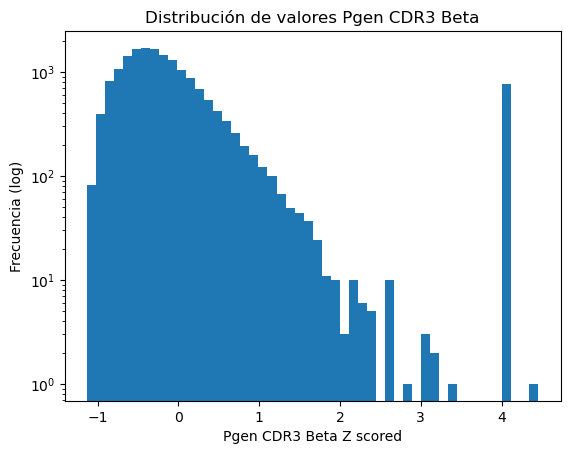

In [16]:
# Histograma de valores Pgen antes del logaritmo
plt.hist(tr.clone_df['pgen_cdr3_a_aa_nlog10_z'], bins=50, log=True)
plt.xlabel("Pgen CDR3 Beta Z scored")
plt.ylabel("Frecuencia (log)")
plt.title("Distribución de valores Pgen CDR3 Beta")
plt.show()

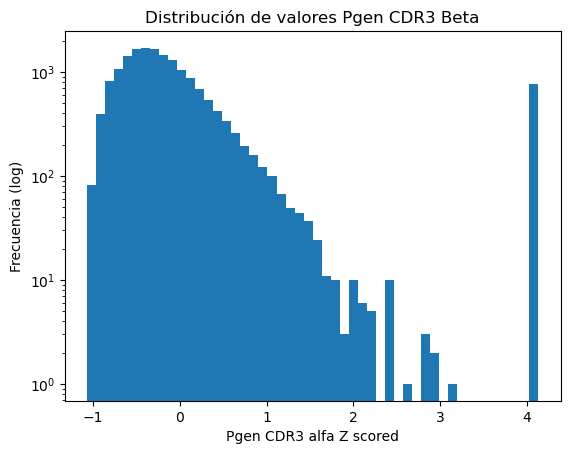

In [19]:
# Histograma de valores Pgen antes del logaritmo
plt.hist(tr.clone_df['pgen_cdr3_a_aa_nlog10_z'], bins=50, log=True)
plt.xlabel("Pgen CDR3 alfa Z scored")
plt.ylabel("Frecuencia (log)")
plt.title("Distribución de valores Pgen CDR3 Beta")
plt.show()

#### Aplicamos sobre cada célula y no clon:

In [27]:
import parmap
import numpy as np
from tcrdist.pgen import OlgaModel
from scipy.stats import zscore

# 1️⃣ Crea el modelo OLGA para la cadena beta (VDJ)
olga_beta = OlgaModel(chain_folder="human_T_beta", recomb_type="VDJ")

# Filtrar solo las secuencias que no son NaN
cdr3_b_validas = airr_tcr['cdr3_b_aa'].dropna()

# Aplica Pgen en paralelo a la cadena beta
pgen_beta = parmap.map(
    olga_beta.compute_aa_cdr3_pgen, 
    cdr3_b_validas, 
    pm_processes=12,  
    pm_pbar=True      
)

# Rellenar la columna `pgen_cdr3_b_aa` con los valores calculados, dejando NaN en las filas que tenían celdas vacías
airr_tcr['pgen_cdr3_b_aa'] = np.nan
airr_tcr.loc[cdr3_b_validas.index, 'pgen_cdr3_b_aa'] = pgen_beta

# 2️⃣ Crea el modelo OLGA para la cadena alfa (VJ)
olga_alpha = OlgaModel(chain_folder="human_T_alpha", recomb_type="VJ")

# Filtrar solo las secuencias que no son NaN
cdr3_a_validas = airr_tcr['cdr3_a_aa'].dropna()

# Aplica Pgen en paralelo a la cadena alfa
pgen_alpha = parmap.map(
    olga_alpha.compute_aa_cdr3_pgen, 
    cdr3_a_validas, 
    pm_processes=12,  
    pm_pbar=True      
)

  0%|          | 0/49043 [00:00<?, ?it/s]

  0%|          | 0/40126 [00:00<?, ?it/s]

In [28]:
# 1️⃣ Rellenar la columna `pgen_cdr3_a_aa` con los valores calculados, dejando NaN donde corresponda
airr_tcr['pgen_cdr3_a_aa'] = np.nan
airr_tcr.loc[cdr3_a_validas.index, 'pgen_cdr3_a_aa'] = pgen_alpha

# 2️⃣ Evitar log(0): obtener el mínimo valor real observado en cada cadena
min_pgen_b = airr_tcr['pgen_cdr3_b_aa'][airr_tcr['pgen_cdr3_b_aa'] > 0].min()
min_pgen_a = airr_tcr['pgen_cdr3_a_aa'][airr_tcr['pgen_cdr3_a_aa'] > 0].min()

# 3️⃣ Si hay ceros, reemplazarlos por el mínimo valor real observado
airr_tcr['pgen_cdr3_b_aa'] = airr_tcr['pgen_cdr3_b_aa'].replace(0, min_pgen_b)
airr_tcr['pgen_cdr3_a_aa'] = airr_tcr['pgen_cdr3_a_aa'].replace(0, min_pgen_a)

# 4️⃣ Aplicar -log10(Pgen) solo en valores no nulos
airr_tcr['pgen_cdr3_b_aa_nlog10'] = np.where(
    airr_tcr['pgen_cdr3_b_aa'].notna(),
    -np.log10(airr_tcr['pgen_cdr3_b_aa']),
    np.nan
)

airr_tcr['pgen_cdr3_a_aa_nlog10'] = np.where(
    airr_tcr['pgen_cdr3_a_aa'].notna(),
    -np.log10(airr_tcr['pgen_cdr3_a_aa']),
    np.nan
)

# 5️⃣ Aplicar Z-score ignorando NaN en el cálculo pero sin eliminarlos en la columna final
airr_tcr['pgen_cdr3_b_aa_nlog10_z'] = (
    airr_tcr['pgen_cdr3_b_aa_nlog10']
    .transform(lambda x: (x - x.mean()) / x.std() if x.notna().sum() > 1 else x)
)

airr_tcr['pgen_cdr3_a_aa_nlog10_z'] = (
    airr_tcr['pgen_cdr3_a_aa_nlog10']
    .transform(lambda x: (x - x.mean()) / x.std() if x.notna().sum() > 1 else x)
)

# 6️⃣ Mostrar información final
print(airr_tcr[['pgen_cdr3_b_aa', 'pgen_cdr3_b_aa_nlog10', 'pgen_cdr3_b_aa_nlog10_z',
                'pgen_cdr3_a_aa', 'pgen_cdr3_a_aa_nlog10', 'pgen_cdr3_a_aa_nlog10_z']].describe())


       pgen_cdr3_b_aa  pgen_cdr3_b_aa_nlog10  pgen_cdr3_b_aa_nlog10_z  \
count    4.904300e+04           49043.000000             4.904300e+04   
mean     5.398498e-08               9.145405             6.965906e-16   
std      2.259856e-07               2.018755             1.000000e+00   
min      8.101521e-26               5.317944            -1.895951e+00   
25%      6.227449e-11               7.691654            -7.201225e-01   
50%      1.299906e-09               8.886088            -1.284538e-01   
75%      2.033977e-08              10.205690             5.252174e-01   
max      4.809014e-06              25.091433             7.898943e+00   

       pgen_cdr3_a_aa  pgen_cdr3_a_aa_nlog10  pgen_cdr3_a_aa_nlog10_z  
count    4.012600e+04           40126.000000             4.012600e+04  
mean     1.144418e-06               7.738296             4.975446e-16  
std      3.214324e-06               2.982120             1.000000e+00  
min      5.764858e-22               4.317338          

In [29]:
airr_tcr

,sample_id,cdr3_alpha,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_beta,cdr3_b_aa,v_b_gene,j_b_gene,clone_id,clone_id_size,pgen_cdr3_b_aa,pgen_cdr3_a_aa,pgen_cdr3_b_aa_nlog10,pgen_cdr3_a_aa_nlog10,pgen_cdr3_b_aa_nlog10_z,pgen_cdr3_a_aa_nlog10_z
cell_id,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1_PT14,PT_14,GCTGTGAGTGGAGGCGGCACAGGCTTTCAGAAACTTGTA,CAVSGGGTGFQKLVF,TRAV8-4*01,TRAJ8*01,GCCAGCAGCTTAGAGTCCCGTGGCAGCGCAGATACGCAGTAT,CASSLESRGSADTQYF,TRBV13*01,TRBJ2-3*01,0,23,2.748758e-10,3.999219e-09,9.560864,8.398025,0.205800,0.221228
AAACCTGAGGACAGAA-1_PT14,PT_14,GCAGAGAATACTGGAGGCTTCAAAACTATC,CAENTGGFKTIF,TRAV13-2*01,TRAJ9*01,GCCAGCAGCCTCCGCGAGGGTAGGACCTACAATGAGCAGTTC,CASSLREGRTYNEQFF,TRBV7-9*03,TRBJ2-1*01,1,1,2.296318e-09,5.764858e-22,8.638968,21.239211,-0.250866,4.527288
AAACCTGAGTGGAGTC-1_PT14,PT_14,GCTCTGAGTGGGGTAGCTGCAGGCAACAAGCTAACT,CALSGVAAGNKLTF,TRAV9-2*02,TRAJ17*01,GCCAGCAGCCAGGACAACCACAATCAGCCCCAGCAT,CASSQDNHNQPQHF,TRBV7-9*03,TRBJ1-5*01,2,1,3.849153e-09,3.855289e-07,8.414635,6.413943,-0.361990,-0.444098
AAACCTGAGTGTCTCA-1_PT14,PT_14,GCTACGGCTAGGGTGCTGAAGCTCAGC,CATARVLKLSF,TRAV17*01,TRAJ20*01,GCCAGCAGCTTAGAGTTGCAGGGGAGTACCCTCGGGCAAGAGACCC...,CASSLELQGSTLGQETQYF,TRBV7-9*03,TRBJ2-5*01,3,1,6.884452e-14,2.558070e-11,13.162131,10.592088,1.989705,0.956967
AAACCTGCAAACTGTC-1_PT14,PT_14,GCAATGAGCGCGTTGAATGCTGGTGGTACTAGCTATGGAAAGCTGACA,CAMSALNAGGTSYGKLTF,TRAV12-3*01,TRAJ52*01,GCCAGCAGCCAACGGCGTCCCCCCTACAATGAGCAGTTC,CASSQRRPPYNEQFF,TRBV3-1*01,TRBJ2-1*01,4,1,1.887728e-09,1.159656e-07,8.724060,6.935671,-0.208715,-0.269146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGTGGCTC-1_PT50,PT_50,GCAATGACCGGGATGAACACAGGCTTTCAGAAACTTGTA,CAMTGMNTGFQKLVF,TRAV12-3*01,TRAJ8*01,GCCAGCAGCTTAGTTGGGACAGGGGATGGCTACACC,CASSLVGTGDGYTF,TRBV5-6*01,TRBJ1-2*01,20321,70,3.391098e-08,2.784671e-08,7.469660,7.555226,-0.830088,-0.061389
TTTGTCATCGTGGGAA-1_PT50,PT_50,GGCACAGAGGAAAATTCTGGGGGTTACCAGAAAGTTACC,CGTEENSGGYQKVTF,TRAV30*01,TRAJ13*02,GCCAGCAGCTTGGGAAAGGATAAAGCTTTC,CASSLGKDKAFF,TRBV5-1*01,TRBJ1-1*01,20317,236,7.684065e-10,1.425560e-08,9.114409,7.846014,-0.015354,0.036121
TTTGTCATCTGCTGCT-1_PT50,PT_50,GCTCTGAGTAAGGTGTCCGGTTCTGCAAGGCAACTGACC,CALSKVSGSARQLTF,TRAV9-2*02,TRAJ22*01,GCCAGCAGTGAGACGGCAGGGGCCTTCCTCTACGAGCAGTAC,CASSETAGAFLYEQYF,TRBV6-1*01,TRBJ2-7*01,20616,16,1.239290e-11,1.772558e-08,10.906827,7.751400,0.872529,0.004394


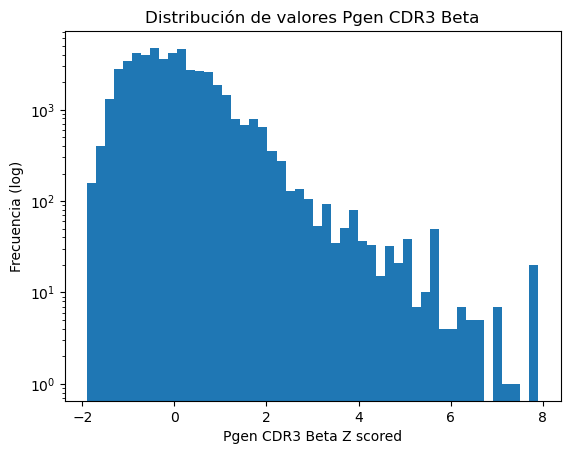

In [33]:
# Histograma de valores Pgen antes del logaritmo
plt.hist(airr_tcr['pgen_cdr3_b_aa_nlog10_z'], bins=50, log=True)
plt.xlabel("Pgen CDR3 Beta Z scored")
plt.ylabel("Frecuencia (log)")
plt.title("Distribución de valores Pgen CDR3 Beta")
plt.show()

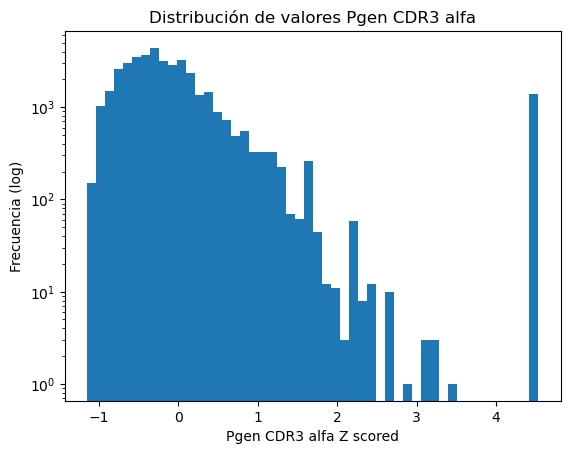

In [38]:
# Histograma de valores Pgen antes del logaritmo
plt.hist(airr_tcr['pgen_cdr3_a_aa_nlog10_z'], bins=50, log=True)
plt.xlabel("Pgen CDR3 alfa Z scored")
plt.ylabel("Frecuencia (log)")
plt.title("Distribución de valores Pgen CDR3 alfa")
plt.show()

Cogemos el tsv el metadata que queremos:

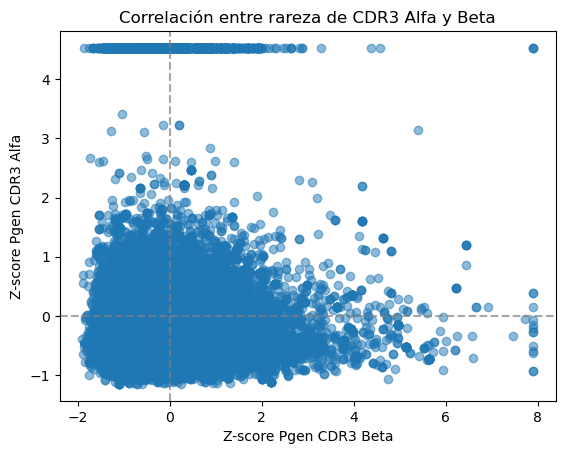

In [42]:
plt.scatter(df_corr['pgen_cdr3_b_aa_nlog10_z'], df_corr['pgen_cdr3_a_aa_nlog10_z'], alpha=0.5)
plt.xlabel("Z-score Pgen CDR3 Beta")
plt.ylabel("Z-score Pgen CDR3 Alfa")
plt.title("Correlación entre rareza de CDR3 Alfa y Beta")
plt.axhline(0, color='gray', linestyle='dashed', alpha=0.7)
plt.axvline(0, color='gray', linestyle='dashed', alpha=0.7)
plt.show()

In [45]:
airr_tcr

,sample_id,cdr3_alpha,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_beta,cdr3_b_aa,v_b_gene,j_b_gene,clone_id,clone_id_size,pgen_cdr3_b_aa,pgen_cdr3_a_aa,pgen_cdr3_b_aa_nlog10,pgen_cdr3_a_aa_nlog10,pgen_cdr3_b_aa_nlog10_z,pgen_cdr3_a_aa_nlog10_z
cell_id,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1_PT14,PT_14,GCTGTGAGTGGAGGCGGCACAGGCTTTCAGAAACTTGTA,CAVSGGGTGFQKLVF,TRAV8-4*01,TRAJ8*01,GCCAGCAGCTTAGAGTCCCGTGGCAGCGCAGATACGCAGTAT,CASSLESRGSADTQYF,TRBV13*01,TRBJ2-3*01,0,23,2.748758e-10,3.999219e-09,9.560864,8.398025,0.205800,0.221228
AAACCTGAGGACAGAA-1_PT14,PT_14,GCAGAGAATACTGGAGGCTTCAAAACTATC,CAENTGGFKTIF,TRAV13-2*01,TRAJ9*01,GCCAGCAGCCTCCGCGAGGGTAGGACCTACAATGAGCAGTTC,CASSLREGRTYNEQFF,TRBV7-9*03,TRBJ2-1*01,1,1,2.296318e-09,5.764858e-22,8.638968,21.239211,-0.250866,4.527288
AAACCTGAGTGGAGTC-1_PT14,PT_14,GCTCTGAGTGGGGTAGCTGCAGGCAACAAGCTAACT,CALSGVAAGNKLTF,TRAV9-2*02,TRAJ17*01,GCCAGCAGCCAGGACAACCACAATCAGCCCCAGCAT,CASSQDNHNQPQHF,TRBV7-9*03,TRBJ1-5*01,2,1,3.849153e-09,3.855289e-07,8.414635,6.413943,-0.361990,-0.444098
AAACCTGAGTGTCTCA-1_PT14,PT_14,GCTACGGCTAGGGTGCTGAAGCTCAGC,CATARVLKLSF,TRAV17*01,TRAJ20*01,GCCAGCAGCTTAGAGTTGCAGGGGAGTACCCTCGGGCAAGAGACCC...,CASSLELQGSTLGQETQYF,TRBV7-9*03,TRBJ2-5*01,3,1,6.884452e-14,2.558070e-11,13.162131,10.592088,1.989705,0.956967
AAACCTGCAAACTGTC-1_PT14,PT_14,GCAATGAGCGCGTTGAATGCTGGTGGTACTAGCTATGGAAAGCTGACA,CAMSALNAGGTSYGKLTF,TRAV12-3*01,TRAJ52*01,GCCAGCAGCCAACGGCGTCCCCCCTACAATGAGCAGTTC,CASSQRRPPYNEQFF,TRBV3-1*01,TRBJ2-1*01,4,1,1.887728e-09,1.159656e-07,8.724060,6.935671,-0.208715,-0.269146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGTGGCTC-1_PT50,PT_50,GCAATGACCGGGATGAACACAGGCTTTCAGAAACTTGTA,CAMTGMNTGFQKLVF,TRAV12-3*01,TRAJ8*01,GCCAGCAGCTTAGTTGGGACAGGGGATGGCTACACC,CASSLVGTGDGYTF,TRBV5-6*01,TRBJ1-2*01,20321,70,3.391098e-08,2.784671e-08,7.469660,7.555226,-0.830088,-0.061389
TTTGTCATCGTGGGAA-1_PT50,PT_50,GGCACAGAGGAAAATTCTGGGGGTTACCAGAAAGTTACC,CGTEENSGGYQKVTF,TRAV30*01,TRAJ13*02,GCCAGCAGCTTGGGAAAGGATAAAGCTTTC,CASSLGKDKAFF,TRBV5-1*01,TRBJ1-1*01,20317,236,7.684065e-10,1.425560e-08,9.114409,7.846014,-0.015354,0.036121
TTTGTCATCTGCTGCT-1_PT50,PT_50,GCTCTGAGTAAGGTGTCCGGTTCTGCAAGGCAACTGACC,CALSKVSGSARQLTF,TRAV9-2*02,TRAJ22*01,GCCAGCAGTGAGACGGCAGGGGCCTTCCTCTACGAGCAGTAC,CASSETAGAFLYEQYF,TRBV6-1*01,TRBJ2-7*01,20616,16,1.239290e-11,1.772558e-08,10.906827,7.751400,0.872529,0.004394


In [46]:
# Definir la ruta de salida
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/TCR_probabilidad_generacion_10_pts.tsv"

# Asegurar que `cell_id` esté como columna y no como índice
airr_tcr.reset_index(inplace=True)  # Si cell_id está en el índice, lo movemos a columna

# Guardar en formato TSV
airr_tcr.to_csv(output_path, sep="\t", index=False)

In [57]:
print("Índice de tr.clone_df después de calcular Pgen:", tr.clone_df.index)

Índice de tr.clone_df después de calcular Pgen: RangeIndex(start=0, stop=17351, step=1)


Integrar Pgen en el análisis permite filtrar y priorizar aquellos clonotipos que, a pesar de tener una baja probabilidad de generarse (lo que los hace raros), muestran muchos vecinos bioquímicamente similares.

Estos clonotipos, al ser poco probables de aparecer por azar pero aparecer repetidamente en diferentes muestras (lo que se refleja en un alto número de vecinos o en la variable qpublic), pueden ser indicativos de una respuesta inmunitaria convergente.

¿Qué se puede hacer con la información de Pgen?

La idea de calcular Pgen es agregar una capa adicional de metadata para que, una vez que tengas los vecinos calculados, puedas:

Filtrar o etiquetar clonotipos:

Por ejemplo, identificar aquellos clonotipos que tienen un valor de -log10(Pgen) alto (lo que indica que son muy poco probables de generarse) y que, a la vez, tienen muchos vecinos o aparecen en varias muestras (qpublic = True). Esto puede ser muy útil para detectar señales de selección convergente.

Visualizar relaciones:

Puedes, por ejemplo, crear gráficos en los que se correlacione -log10(Pgen) con el número de vecinos o con el número de sujetos (nsubject).

6. Identificar Vecinos y Caracterizar los Clones

Con el radio específico calculado para cada clon, el siguiente paso es identificar los vecinos dentro de ese radio. Esto se puede hacer utilizando las funciones internas de TCRdist3,

In [98]:
import numpy as np

# Extraer distancias no nulas de rw_beta
distancias_no_cero = tr.rw_beta.data
print("Percentiles de las distancias en rw_beta:", np.percentile(distancias_no_cero, [0, 25, 50, 75, 100]))


Percentiles de las distancias en rw_beta: [  3. 129. 145. 162. 311.]


In [99]:
print("Shape de rw_beta:", tr.rw_beta.shape)
print("Índice de tr.clone_df después de recalcular distancias:", tr.clone_df.index)

Shape de rw_beta: (17351, 17351)
Índice de tr.clone_df después de recalcular distancias: RangeIndex(start=0, stop=17351, step=1)


Además, puedes calcular la cantidad de sujetos únicos (si tienes esa información en tus metadatos) para determinar si un clon es "quasi-public" (público) o privado:

#### Aplicamos reducciones de la dimensionalidad

In [16]:
import numpy as np

# Verificar forma de la matriz de distancias
print(f"Shape de pw_beta: {tr.pw_beta.shape}")

# Ver percentiles de distancia
percentiles = np.percentile(tr.pw_beta[tr.pw_beta > 0], [10, 25, 50, 75, 90])
print(f"Percentiles de distancia: {percentiles}")

Shape de pw_beta: (17351, 17351)
Percentiles de distancia: [112. 129. 145. 162. 177.]


In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Asegurar que la matriz de distancias está en formato numpy
pw_beta_dense = np.array(tr.pw_beta)

# Aplicar Min-Max Scaling (0 = más cercano, 1 = más lejano)
scaler = MinMaxScaler()
pw_beta_scaled = scaler.fit_transform(pw_beta_dense)

# Verificar resultado
print(f"Distancias escaladas (min, max): {pw_beta_scaled.min(), pw_beta_scaled.max()}")


Distancias escaladas (min, max): (np.float64(0.0), np.float64(1.0))


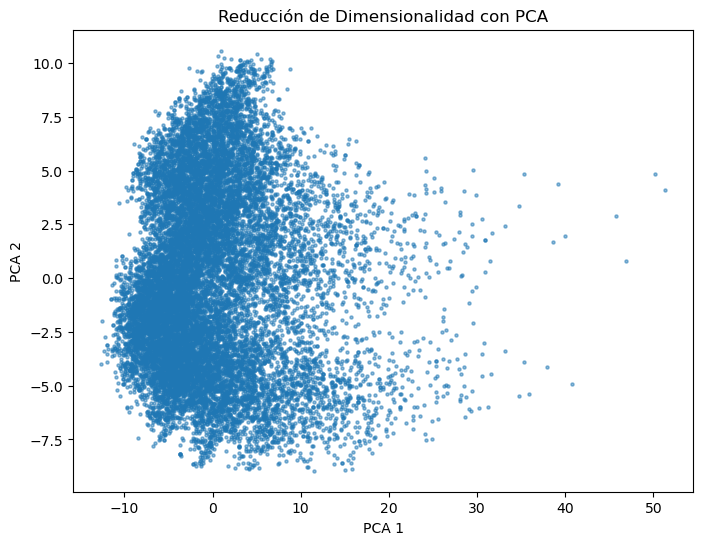

In [124]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA a la matriz de distancias escaladas
pca = PCA(n_components=2)
pw_beta_pca = pca.fit_transform(pw_beta_scaled)

# Graficar resultado de PCA
plt.figure(figsize=(8, 6))
plt.scatter(pw_beta_pca[:, 0], pw_beta_pca[:, 1], s=5, alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Reducción de Dimensionalidad con PCA")
plt.show()


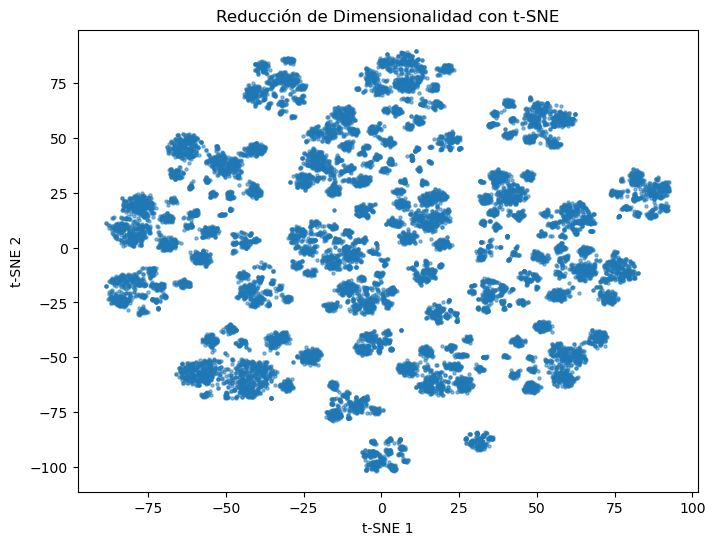

In [127]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Aplicar t-SNE con init='random' para evitar el error
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, init="random", random_state=42)
pw_beta_tsne = tsne.fit_transform(pw_beta_scaled)

# Graficar resultado de t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(pw_beta_tsne[:, 0], pw_beta_tsne[:, 1], s=5, alpha=0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Reducción de Dimensionalidad con t-SNE")
plt.show()


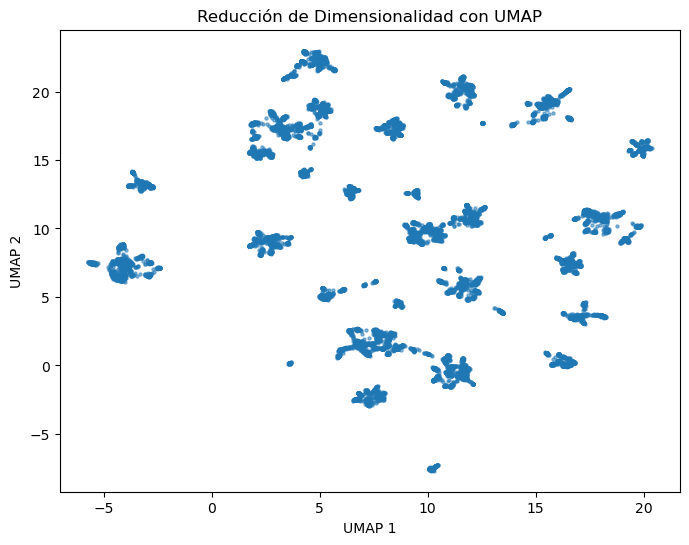

In [126]:
import umap

# Aplicar UMAP a la matriz de distancias escaladas
umap_model = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
pw_beta_umap = umap_model.fit_transform(pw_beta_scaled)

# Graficar resultado de UMAP
plt.figure(figsize=(8, 6))
plt.scatter(pw_beta_umap[:, 0], pw_beta_umap[:, 1], s=5, alpha=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Reducción de Dimensionalidad con UMAP")
plt.show()


In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

In [ ]:
# Aplicamos UPGMA al conjunto de datos escalado
linkage_matrix = linkage(pw_beta_scaled, method='average')  # Método UPGMA = 'average'

# Dibujar el dendrograma para visualizar la estructura de los clusters
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode="level", p=10)  # Mostramos hasta 10 niveles
plt.title("Dendrograma - Clustering Jerárquico UPGMA")
plt.xlabel("Índices de clones")
plt.ylabel("Distancia")
plt.show()

In [ ]:
# Evaluar el coeficiente de silueta para distintos cortes
num_clusters = list(range(2, 15))  # Probamos entre 2 y 15 clusters
silhouette_scores = []

for k in num_clusters:
    labels = fcluster(linkage_matrix, k, criterion="maxclust")  # Asignar clusters
    score = silhouette_score(pw_beta_scaled, labels, metric="precomputed")  # Evaluamos silueta
    silhouette_scores.append(score)

# Graficamos la puntuación de silueta
plt.figure(figsize=(8, 4))
plt.plot(num_clusters, silhouette_scores, marker="o")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silueta")
plt.title("Selección del Número Óptimo de Clusters")
plt.show()

# Seleccionamos el mejor número de clusters basado en silueta
best_k = num_clusters[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters según Silueta: {best_k}")

In [ ]:
# Asignamos clusters usando el número óptimo encontrado
tr.clone_df["cluster"] = fcluster(linkage_matrix, best_k, criterion="maxclust")

# Mostramos un resumen del clustering
print(tr.clone_df["cluster"].value_counts())

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=tr.clone_df["cluster"], palette="tab10", s=5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Clusters Jerárquicos sobre UMAP")
plt.legend(title="Cluster")
plt.show()